In [63]:
import tensorflow as tf
print ("TensorFlow version: " + tf.__version__)
import matplotlib.pyplot as plt
import pandas as pd
import glob
import os

TensorFlow version: 2.17.0


Load Dataset
 Each File has 31 rows and 4 columns. The first 3 columns indicate heart rate, respiratory rate, and oxygen saturation of a baby; the last column indicates if the baby is in pain or not (0 means no pain, 1 means slight pain, 2 means severe pain, # means label is missing).


In [64]:
data_dir = "./Data/"
csv_files = glob.glob(data_dir + "/**/*.csv", recursive=True) # get all csv files in the data directory
combined_csv = pd.concat([pd.read_csv(f, header=None) for f in csv_files], ignore_index=True) # combine all csv files into one dataframe
combined_csv.drop(columns=[0], inplace=True) # drop the first column (index)
combined_csv = combined_csv[combined_csv.iloc[:, 3] != "#"] # remove rows with "#" in the 4th column
combined_csv # display the combined dataframe


,1,2,3,4
0,142,60,100,0
1,142,60,100,0
2,142,60,100,0
3,142,59,100,0
4,143,59,100,0
...,...,...,...,...
18657,169,19,98,1
18658,164,50,98,1
18659,164,74,98,1
18660,162,39,99,1


In [65]:
#  Shuffle dataset
from sklearn.utils import shuffle
combined_csv = shuffle(combined_csv)

In [66]:
# Split Dataset
from sklearn.model_selection import train_test_split

train, valid = train_test_split(combined_csv, test_size=0.1) # split the dataset into 90% training and 10% validation (test) sets
train_x = train.iloc[:, 0:3] # get the first 3 columns as input features for training
train_y = train.iloc[:, 3] # get the 4th column as the target output for training
valid_x = valid.iloc[:, 0:3] # get the first 3 columns as input features for validation
valid_y = valid.iloc[:, 3] # get the 4th column as the target output for validation

In [67]:
# Convert to numeric
train_x = train_x.apply(pd.to_numeric, errors='coerce')
valid_x = valid_x.apply(pd.to_numeric, errors='coerce')
train_y = train_y.apply(pd.to_numeric, errors='coerce')
valid_y = valid_y.apply(pd.to_numeric, errors='coerce')

In [68]:
# Normalize Dataset
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler() # initialize scaler

# Fit scaler on training data & transform training data
# train_x = scaler.fit_transform(train_x)
# valid_x = scaler.transform(valid_x)

In [69]:
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

model = Sequential()

model.add(Input(shape=(train_x.shape[1],))) # Input Layer

# Input and Hidden Layers
model.add(Dense(64, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2)) # regularization
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))

# Output Layer (multi class classification, softmax for 3 classes)
model.add(Dense(3, activation='softmax'))

# Compile Model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [70]:
# Train Model
history = model.fit(train_x, train_y, epochs=20, batch_size=32, validation_data=(valid_x, valid_y))


Epoch 1/20
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 905us/step - accuracy: 0.5341 - loss: 1.7227 - val_accuracy: 0.5655 - val_loss: 0.9086
Epoch 2/20
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step - accuracy: 0.5685 - loss: 0.8740 - val_accuracy: 0.5655 - val_loss: 0.8602
Epoch 3/20
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step - accuracy: 0.5661 - loss: 0.8615 - val_accuracy: 0.5655 - val_loss: 0.8609
Epoch 4/20
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step - accuracy: 0.5578 - loss: 0.8737 - val_accuracy: 0.5655 - val_loss: 0.8605
Epoch 5/20
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step - accuracy: 0.5695 - loss: 0.8691 - val_accuracy: 0.5655 - val_loss: 0.8607
Epoch 6/20
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step - accuracy: 0.5573 - loss: 0.8718 - val_accuracy: 0.5655 - val_loss: 0.8609
Epoch 7/20
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step - accuracy: 0.5646 - loss: 0.8674 - val_accuracy: 0.5655 - val_loss: 0.8603
Epoch 8/20
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step - accuracy: 0.5649 - loss: 0.8660 - 

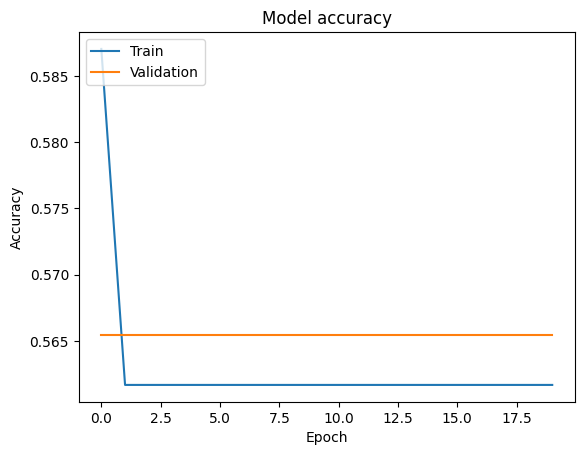

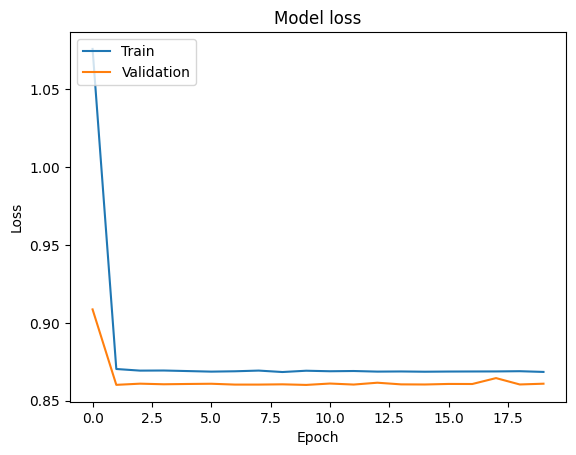

In [71]:
# Visualize Results

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
